# NITRIFICATION MODEL

Author: Emiel Kruisdijk, Ali Moradvandi;  Date: 14-09-2022

The model is based on data from the article: 
de Kreuk 2007 BB Kinetic model of a granular sludge SBR: Influences on nutrient removal

https://onlinelibrary.wiley.com/doi/abs/10.1002/bit.21196

## Introduction

Welcome to this nitrification model made in jupyter notebook! In this notebook, we try to guide you through the nitrification model step by step. The aim of this workshop is to show that modelling can substantially decrease the effort needed for data analysis.

**Before you start, team up in groups of 2 for this workshop.**

The notebook is not fully ready to run the model. We wrote down some comments here and there in the cells of the notebook, read those comments carefully, and finish the code where needed. The locations where the code needs to be adjusted are signalled with the symbols **#!**. We finish the script with a couple of questions that need to be answered. Please make a new cell below the cell with the question, and write your answer in this cell.

If you do not know how to finish the code, ask your question first to an online search engine or consult stackoverflow.com. Stackoverflow is a public Q&A platform. The question you have is often already answered there. Still problems? Do not hesitate to consult us! 

Good luck finishing the model!


In [4]:
#First, we will open all packages that are needed for the model and data analysis
#A python package is a directory with prefab python modules, which can be used in your script.

#The pandas package is made for data analysis, and can be somewhat compared with microsoft excel
import pandas as pd

#Numpy is the package for scientific computing with python.

#! IMPORT THE NUMPY PACKAGE HERE AS NP

#The SciPy package provides algorithms for optimization, integration, interpolation etc. Here we import specifically the
#modules related to integration
from scipy.integrate import odeint

#The pyplot package is often used for visualization of results.

#! IMPORT PYPLOT AS PLT FROM MATPLOTLIB

## Nitrification reaction equations

Nitrification is a two-step biological process, in which $NH_{4}$ is transformed to $NO_{3}$ with $NO_{2}$ as an intermittent product. The reaction equations below represent this process:

Step 1: $$ NH_{4}^{+} + 1.5O_{2}  \Rightarrow  NO_{2}^{-} + H_{2}O + 2H^{+} $$

Step 2: $$ NO_{2}^{-} + 0.5O_{2} \Rightarrow NO_{3}^{-} $$

Both reactions are extensively researched, during which rate equations are developed. These rate equations are used to simulate both steps of nitrification in this model.

## Rate equation nitrification (step 1 - AOB)

Nitrification (Step 1):

The equation below can be used to estimate the  process rate of the first step of nitrification. It is a Monod-type rate equation, which is often used to present biological conversion processes. The equation is a differential equation, which can be used to calculate the rate of the biological conversion (thus: change of concentration over a period of time, dS/dT)

$$ Process\ rate\ 1 \equiv \mu _{max}^{AOB} . \frac{S_{O_{2}}}{K_{O_{2}}^{AOB}+S_{O_{2}}} . \frac{S_{NH}}{K_{NH}^{AOB}+S_{NH}} . X_{AOB}$$

where $\mu_{max}^{AOB}$ is the maximum growth rate of ammonium oxidizing bacteria (AOB), $S_{i}$ the concentration of solute $i$, $K_{i}$ the half-saturation coefficient of $i$, and $X_{AOB}$ is the COD concentration.

The values of these parameters in the rate equation are defined below.

## Rate equation nitrification (step 2 - NOB)

Nitrification (Step 2):

A similar type of equation can be used to estimate the process rate of the second step of nitrification.

Rate equation:

$$ Process \ rate\ 2 \equiv \mu _{max}^{NOB} . \frac{S_{O_{2}}}{K_{O_{2}}^{NOB}+S_{O_{2}}} . \frac{S_{NO_{2}}}{K_{NO_{2}}^{NOB}+S_{NO_{2}}} . X_{NOB}$$

where $\mu_{max}^{NOB}$ is the maximum growth rate of nitrite oxidizing bacteria (NOB), and $X_{NOB}$ is the COD concentration.

The values of the parameters in the rate equation are defined below.

## Parameters used in simulation
Below all parameters are shown, which are used in the simulation. The names of the parameters in the rate equations shown before can be different than the names used in the code. The parameter names in the code are shown for each parameter at the end of the sentence.

Maximum specific growth rate (Xnh)  µ$_{NH}$ = 0.4 d$^{-1}$ --> In model unh

Maximum specific growth rate (Xno)  µ$_{NO}$ = 1.1 d$^{-1}$ --> In model uno

Nitrogen content of biomass  i$_{nbm}$ = 0.07 gN x gCOD$^{-1}$ --> In model inbm

Yield for growth of ammonium oxidizers  Y$_{NH}$ = 0.15 gCOD x gN$^{-1}$ --> In model Ynh

Yield for growth of nitrite oxidizers  Y$_{NO}$ = 0.041 gCOD x gN$^{-1}$ --> In model Yno

Half-saturation coefficient for oxygen (Xnh)  K$_{O2,NH}$ = 0.3 --> In model KO2nh

Half-saturation coefficient for ammonium (Xnh)  K$_{NH4,NH}$ = 2.4 --> In model Knh

Half-saturation coefficient for oxygen (Xno)  K$_{O2,NO}$ = 0.1 --> In model KO2no

Half-saturation coefficient for nitrite (Xno)  K$_{NO2,NO}$ = 0.238 --> In model KNO2no

In [2]:
#Parameters used in simulation

unh=0.4 #maximum specific growth rate (Xnh)

#! FILL IN THE OTHER PARAMETERS BELOW, BASED ON THE DATA PROVIDED IN THE TEXT ABOVE

mu_AOB    =                  # Maximum specific growth rate (X_AOB) [d-1]
mu_NOB    =                  # Maximum specific growth rate (X_NOB) [d-1]

inbm      =                  # Nitrogen content of biomass [gN x gCOD-1]

Y_AOB     =                  # Yield for growth of ammonium oxidizers [mgCOD/mgN]
Y_NOB     =                  # Yield for growth of nitrite oxidizers  [mgCOD/mgN]


K_O2_AOB  =                  # Half-saturation coefficient for oxygen (X_AOB)
K_NH4_AOB =                  # Half-saturation coefficient for ammonium (X_AOB)
K_O2_NOB  =                  # Half-saturation coefficient for oxygen (X_NOB)
K_NO2_NOB =                  # Half-saturation coefficient for nitrite (X_NOB)  

## Stoichiometric Matrix

| Process $\downarrow$ |  Component $\rightarrow$ | $S_{O_2}$ | $S_{NH_4}$ | $S_{NO_3}$ | $S_{NO_2}$ | $X_{AOB}$ | $X_{NOB}$ |Rates |
|---------|:-|:-|:-|:-|:-|:-|:-|:-|
|Growth AOB|  | $1-\frac{3.43}{Y_{AOB}}$ | $\frac{-1}{Y_{AOB}} - i_{nbm}$ | | $\frac{1}{Y_{AOB}}$  | $1$ |  | Process rate 1 |  
|Growth NOB|  | $1-\frac{1.14}{Y_{NOB}}$ | $\frac{1}{Y_{NOB}}$ | $\frac{1}{Y_{NOB}}$ | $\frac{-1}{Y_{NOB}} - i_{nbm}$ |  | $1$ | Process rate 2 | 

The figure above shows the stoichiometric matrix. This matrix shows the rates for the specific bioconversion processes. 

**How to use this matrix?**

The matrix can be used in the following two steps:
1. The process rate needs to be estimated using the Monod-type rate equations shown above. 
2. The estimated process rate needs to be multiplied with the term found in the above table for the specific parameter that is estimated.

For example, let us calculate the change in oxygen concentration (S$_{O_{2}}$) during the first step of nitrification. This can be done by multiplying the process rate by the rate for the bioconversion of O$_{2}$. Combining both formulas you will end up with the following equation:

$$ Process \ rate \ O_{2} = (1-\frac{3.43}{Y_{NH}}) . \mu _{max}^{AOB} . \frac{S_{O_{2}}}{K_{O_{2}}^{AOB}+S_{O_{2}}} . \frac{S_{NH}}{K_{NH}^{AOB}+S_{NH}} . X_{AOB}$$

The last step is to plot the O$_2$ concentrations over time. And, therefore, we need to solve the differential equation. Luckily, we do not have to solve the differential equation ourselve. Python has packages which can solve differential equations. In this case, we use the odeint modul from the scipy.integrate package.

For more information about this solver, see:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

These steps above should be repeated for the other solutes and biomass involved in nitrification. After all these steps are taken, the data needs to be plotted in a nice figure. The steps explained above are performed in the model shown below.

## Simulating nitrification over time

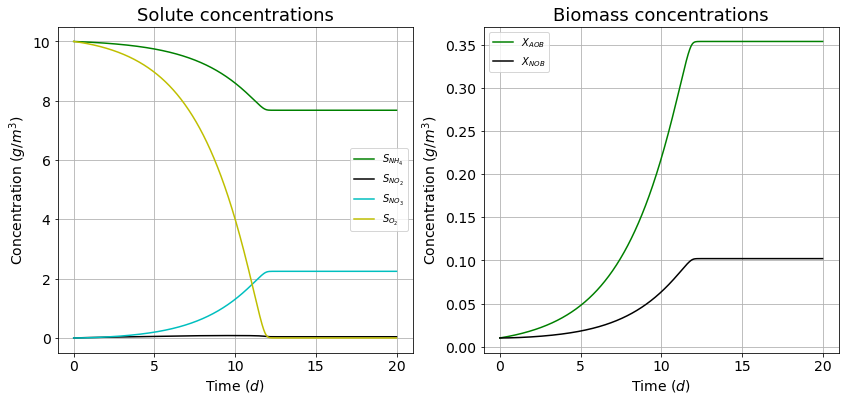

In [5]:
# Define the model in differential-equation format
def odes(x,t):
    #First step nitrification
    # assign each ODE to a vector element
    X_AOB  = x[0]
    S_NH4  = x[1]
    S_O2   = x[2]
    S_NO2  = x[3]
    S_NO3  = x[4]
    X_NOB  = x[5]
    
    # define process rates
    Pr_r_1 = mu_AOB*(S_O2/(K_O2_AOB + S_O2))*(S_NH4/(K_NH4_AOB + S_NH4))*X_AOB       #Process rate 1
    Pr_r_2 = mu_NOB*(S_NO2/(K_NO2_NOB + S_NO2))*(S_O2/(K_O2_NOB + S_O2))*X_NOB    #Process rate 2  
    
    #define each ODE
    dX_AOB  = Pr_r_1
    dS_NH4  = (-1/Y_AOB - inbm)*Pr_r_1
    dS_O2   = (1 - (3.43/Y_AOB))*Pr_r_1 + (1 - (1.14/Y_NOB))*Pr_r_2
    dS_NO2  = (1/Y_AOB)*Pr_r_1 + (-1/Y_NOB - inbm)*Pr_r_2
    dS_NO3  = (1/Y_NOB)*Pr_r_2
    dX_NOB  = Pr_r_2
   
    return [dX_AOB, dS_NH4, dS_O2, dS_NO2, dS_NO3, dX_NOB]

# Define initial conditions
x0 = [0.01, 10, 10, 0, 0, 0.01]

# test the defined odes
#print(odes(x=x0, t=0))

# Declare a time vector (time window)
#! VISIT https://numpy.org/doc/stable/reference/generated/numpy.linspace.html AND FILL IN THE EQUATION BELOW
#! t REPRESENTS THE TIME INTERVAL FOR WHICH THE DIFFERENTIAL EQUATIONS ARE SOLVED, WHAT IS AN INSIGHTFUL TIME INTERVAL?
#! AND WHAT A SUFFICIENT TIMESTEP?
t = np.linspace(???)

# Solve the ODE equations
x = odeint(odes, x0, t)

X_AOB  = x[:,0]
S_NH4  = x[:,1]
S_O2   = x[:,2] 
S_NO2  = x[:,3] 
S_NO3  = x[:,4]
X_NOB  = x[:,5]

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) #this function plots an empty figure, which will be filled
ax2.plot(t, X_AOB, color='g', label='$X_{AOB}$')
ax2.plot(t, X_NOB, color='k', label='$X_{NOB}$')
ax1.plot(t, S_NH4, color='g', label='$S_{NH_4}$')
ax1.plot(t, S_NO2, color='k', label='$S_{NO_2}$')
ax1.plot(t, S_NO3, color='c', label='$S_{NO_3}$')
ax1.plot(t, S_O2,  color='y', label='$S_{O_2}$')

#The lines below are used to create a 'nice' lay-out of the figure
ax1.grid()
ax2.grid()
ax1.set_xlabel('Time ($d$)', fontsize=14)
ax1.set_ylabel('Concentration ($g/m^{3}$)', fontsize=14)
ax2.set_xlabel('Time ($d$)', fontsize=14)
ax2.set_ylabel('Concentration ($g/m^{3}$)', fontsize=14)
ax1.set_title('Solute concentrations',  fontsize=18)
ax2.set_title('Biomass concentrations', fontsize=18)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax1.legend()
ax2.legend()

## Questions

Q1. Based on the outcome of the simulation: When would you measure NH$_{4}$ concentrations over time, keeping in mind the time and financial constraints of the experiment? And when for NO$_{2}$, and NO$_{3}$?

Q2. Change the parameter uno to 0. What is happening now? How can we explain the changes occurring in the plot?

Q3. The system simulated is a closed experiment, where O2 is slowly reduced. Can you change the model so that O$_{2}$ concentrations are constant over time?